# TP 3.2 : Gain et impact de marché

**Hugo Yeremian, Martín Pasche**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Gain de catégories d'investisseurs

### 1. Calculer le gain moyen des producteurs et des spéculateurs en variant Ns tout autres paramètres étant fixés. Comment ces gains évoluent-ils en fonction de Ns?

In [2]:
Ns = 100 
P = 4  
epsilon = 0.01 
Np = 10*P  
M = np.log(P)/np.log(2)

time_steps = int(300 * P / epsilon)

def update_system(Ns, P, Omega, a, U_t, mu_t, epsilon, M):
    n = np.where(U_t>0, 1, 0)
    A_t_prod = Omega[mu_t]
    A_t_spec = np.sum(n * a[:, mu_t]) 
    A_t = A_t_prod + A_t_spec 
    U_t = U_t - a[:, mu_t] * A_t - epsilon
    
    heaviside_ = 1 if A_t>0 else 0
    mu_t = int((2*mu_t) % P + heaviside_)
    
    return U_t, mu_t, A_t, A_t_prod, A_t_spec

def run(time_steps, Ns, Np, P, epsilon, M, a_best=None):
    Omega = np.random.normal(0, np.sqrt(Np), P)
    a = np.random.choice([-1, 1], (Ns, P))
    U = np.zeros(Ns)
    mu_t = np.random.randint(0, P)
    
    if a_best is not None:
        a[-1, :] = a_best.flatten()

    A_t_values = np.zeros(time_steps)
    A_t_prod_values = np.zeros(time_steps)
    A_t_spec_values = np.zeros(time_steps)
    mu_t_values = np.zeros(time_steps)
    U_values = np.zeros((time_steps, Ns))
    n_values = np.zeros((time_steps, Ns))
    for t in range(time_steps):
        U, mu_t, A_t, A_t_prod, A_t_spec = update_system(Ns, P, Omega, a, U, mu_t, epsilon, M)
        A_t_values[t] = A_t
        A_t_prod_values[t] = A_t_prod
        A_t_spec_values[t] = A_t_spec
        mu_t_values[t] = mu_t
        U_values[t] = U
        n_values[t] = np.heaviside(U, 0)
    
    if a_best is not None:
        return A_t_values, mu_t_values, U_values, A_t_prod_values, A_t_spec_values, n_values, a
    return A_t_values, mu_t_values, U_values, A_t_prod_values, A_t_spec_values, n_values

In [3]:
def compute_mean_gain_prod(A_t_values, A_t_prod_values, mu_t_values, P):
    A_mu = pd.DataFrame({"A" : A_t_values, "A_prod": A_t_prod_values, "mu": mu_t_values})
    A_mu["G_prod"] = -A_mu["A"]*A_mu["A_prod"]
    A_mu = A_mu.groupby(["mu"]).mean()
    G = A_mu["G_prod"].sum()
    G /= (P * Ns)
    return G  

def compute_mean_gain_spec(A_t_values, A_t_spec_values, mu_t_values, P):
    A_mu = pd.DataFrame({"A" : A_t_values, "A_spec": A_t_spec_values, "mu": mu_t_values})
    A_mu["G_spec"] = -A_mu["A"]*A_mu["A_spec"]
    A_mu = A_mu.groupby(["mu"]).mean()
    G = A_mu["G_spec"].sum()
    G /= (P * Ns)
    return G  

In [4]:
N_s_values = np.logspace(1, 3, 50)
Gprod = []
Gspec = []
for N_s in tqdm(N_s_values):
    A_t_values, mu_t_values, U_values, A_t_prod_values, A_t_spec_values, n_values = run(time_steps, int(N_s), Np, P, epsilon, M)
    Gprod.append(compute_mean_gain_prod(A_t_values, A_t_prod_values, mu_t_values, P))
    Gspec.append(compute_mean_gain_spec(A_t_values, A_t_spec_values, mu_t_values, P))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:57<00:00,  2.34s/it]


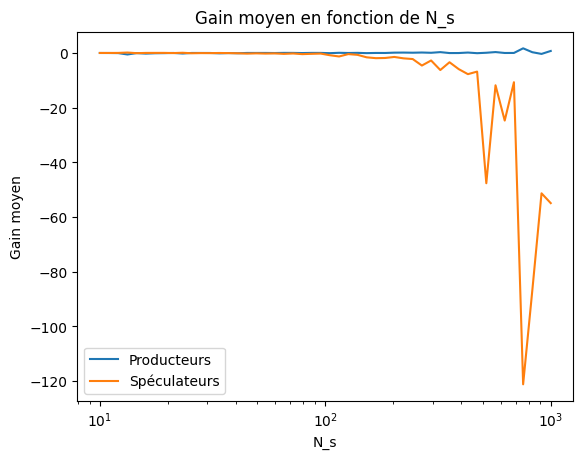

In [5]:
plt.plot(N_s_values, Gprod, label = "Producteurs")
plt.plot(N_s_values, Gspec, label = "Spéculateurs")
plt.xlabel("N_s")
plt.xscale("log")
plt.ylabel("Gain moyen")
plt.title("Gain moyen en fonction de N_s")
plt.legend()

* **Zone $N_s \lesssim 40$**  
  Les gains moyens par producteur **et** par spéculateur sont très proches de 0. Le marché est encore « sous‑exploité » : la population de prédateurs (spéculateurs) est trop petite pour extraire la moindre rente significative.

* **Croissance de $N_s$**  
  À partir d’une centaine de spéculateurs, on voit la courbe orange (spéculateurs) plong­er brutalement vers des valeurs négatives tandis que les producteurs restent globalement à l’équilibre.  
  ↳ **Interprétation écologique** : le jeu minoritaire fonctionne comme un écosystème « proie/prédateur ». Les producteurs fournissent une ressource (l’offre fixe $\Omega_\mu$). Tant que la densité de prédateurs est raisonnable, chacun peut se nourrir ; au‑delà d’un seuil, la compétition entre spéculateurs fait chuter leur profit moyen, parfois jusqu’à la famine (gains fortement négatifs).

* **Plateau des producteurs**  
  Les producteurs, eux, n’améliorent pas leur sort lorsque la pression spéculative augmente : leur rôle de « ressource passive » les condamne à un rendement proche de 0 quel que soit $N_s$.  
  Ce résultat est cohérent avec la théorie : le jeu est à somme nulle (hors $\varepsilon$) et l’essentiel des pertes se concentre sur la catégorie trop nombreuse.


In [ ]:
n_runs = 30                   
N_s_values = np.logspace(1, 3, 50, dtype=int)  
Gprod_mean, Gprod_std = [], []
Gspec_mean, Gspec_std = [], []


for Ns in tqdm(N_s_values, desc='Scanning Ns'):
    gprod_runs, gspec_runs = [], []

    for _ in range(n_runs):
        A_t, mu_t, U, A_prod, A_spec, n = run(
            time_steps=time_steps,
            Ns=int(Ns),
            Np=Np,
            P=P,
            epsilon=epsilon,
            M=M
        )
        gprod_runs.append(compute_mean_gain_prod(A_t, A_prod, mu_t, P))
        gspec_runs.append(compute_mean_gain_spec(A_t, A_spec, mu_t, P))

    Gprod_mean.append(np.mean(gprod_runs))
    Gprod_std .append(np.std (gprod_runs))
    Gspec_mean.append(np.mean(gspec_runs))
    Gspec_std .append(np.std (gspec_runs))

Gprod_mean = np.array(Gprod_mean);  Gprod_std = np.array(Gprod_std)
Gspec_mean = np.array(Gspec_mean);  Gspec_std = np.array(Gspec_std)


Scanning Ns:  28%|██▊       | 14/50 [14:11<39:10, 65.29s/it]

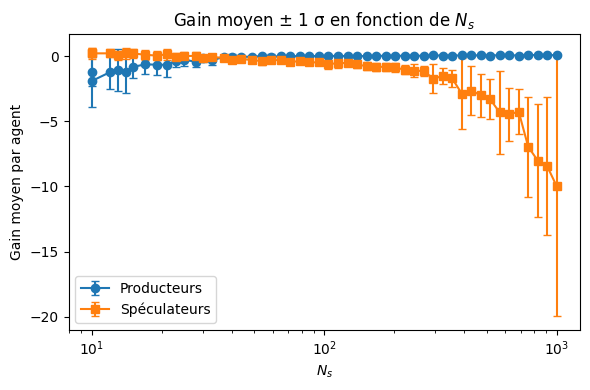

In [ ]:
plt.figure(figsize=(6,4))

plt.errorbar(N_s_values, Gprod_mean, yerr=Gprod_std,
             fmt='o-', capsize=3, label='Producteurs')
plt.errorbar(N_s_values, Gspec_mean, yerr=Gspec_std,
             fmt='s-', capsize=3, label='Spéculateurs')

plt.xscale('log')
plt.xlabel('$N_s$')
plt.ylabel('Gain moyen par agent')
plt.title('Gain moyen ± 1 σ en fonction de $N_s$')
plt.legend()
plt.tight_layout()
plt.show()

On se rend compte que plus le nombre de spéculateurs augmente, moins il y a de gain à récupérer.

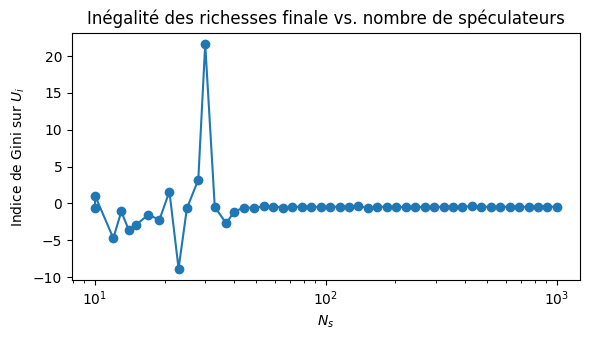

In [ ]:
def gini(x):
    x = np.sort(x)
    n = len(x)
    # éviter division par zéro si somme(x) = 0
    if np.allclose(np.sum(x), 0):
        return 0.0
    return (2*np.sum((np.arange(1, n+1))*x)/(n*np.sum(x))) - (n+1)/n

gini_values = []
N_s_values = np.logspace(1, 3, 50, dtype=int)

for Ns_gini in N_s_values:
    _, _, U, _, _, _ = run(
        time_steps=time_steps,
        Ns=int(Ns_gini),
        Np=Np,
        P=P,
        epsilon=epsilon,
        M=M
    )
    gini_values.append(gini(U[-1]))   # dernier pas de temps

plt.figure(figsize=(6, 3.5))
plt.plot(N_s_values, gini_values, marker='o')
plt.xscale('log')
plt.ylabel('Indice de Gini sur $U_i$')
plt.xlabel('$N_s$')
plt.title('Inégalité des richesses finale vs. nombre de spéculateurs')
plt.tight_layout()
plt.show()


On voit que l'indicateur de Gini montre que la richesse finale est stabilisée par le nombre de spéculateurs.

### 2. Prenez des paramètres pour lesquelle le gain des spéculateurs est négatif et augmenter Np. Comment ces gains évoluent-ils en fonction de Np?

In [ ]:
N_p_values = np.logspace(1, 3, 50)
Gprod = []
Gspec = []
for N_p in tqdm(N_p_values):
    A_t_values, mu_t_values, U_values, A_t_prod_values, A_t_spec_values, n_values = run(time_steps, Ns, int(N_p), P, epsilon, M)
    Gprod.append(compute_mean_gain_prod(A_t_values, A_t_prod_values, mu_t_values, P))
    Gspec.append(compute_mean_gain_spec(A_t_values, A_t_spec_values, mu_t_values, P))

100%|██████████| 50/50 [00:59<00:00,  1.20s/it]


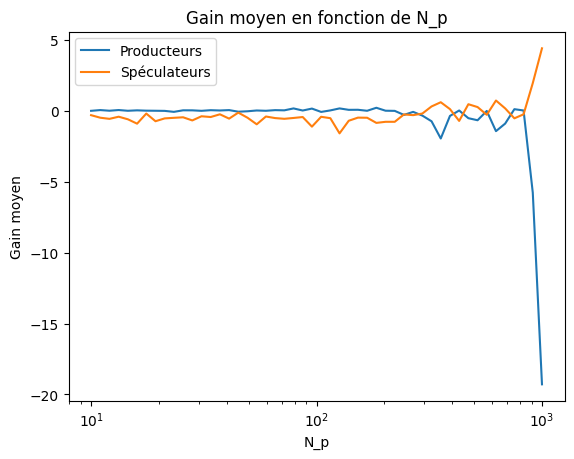

In [ ]:
plt.plot(N_p_values, Gprod, label = "Producteurs")
plt.plot(N_p_values, Gspec, label = "Spéculateurs")
plt.xlabel("N_p")
plt.xscale("log")
plt.ylabel("Gain moyen")
plt.title("Gain moyen en fonction de N_p")
plt.legend()

* **Paramètres de départ** : on s’est placé dans une zone où le gain moyen des spéculateurs était négatif ; puis on a fait varier $N_p$(producteurs).

* **Effet d’un $N_p$ croissant**  
  Lorsque $N_p$ augmente, l’offre fixe $\Omega_\mu$ devient plus volumineuse ; en langage écologique, on enrichit l’environnement en ressources.  
  On observe alors :
  - le gain moyen des producteurs **baisse** : l’agrégat $A_\mu$ est désormais dominé par leur propre contribution, donc leurs pertes augmentent;  
  - le gain des spéculateurs **remonte** vers 0, voire légèrement positif pour les très grandes valeurs de $N_p$.

* **Lien proie‑prédateur**  
  Plus il y a de proies (producteurs), mieux se portent les prédateurs (spéculateurs). Mais si le nombre de proies devient excessif, la ressource dépasse la capacité d’arbitrage minoritaire, le marché se décorrèle et les profits spéculatifs finissent par s’annuler.


### 3. Comment décrire la relation entre ces deux catégories d'investisseurs en empruntant le langage de l'écologie de populations.

Les producteurs jouent le rôle d’une ressource stationnaire : leur offre fixe correspond à la biomasse disponible dans un écosystème.
Les spéculateurs forment une population prédatrice qui se nourrit de cette ressource ; leur profit moyen diminue lorsque leur densité dépasse la « capacité de charge » du marché.
Lorsque le ratio prédateurs/proies s’équilibre, le système atteint une co‑existence stable avec des gains proches de zéro pour tous.
Si l’on enrichit l’environnement en producteurs, on observe un rebond prédateur (hausse des gains spéculateurs) jusqu’à ce qu’un nouvel excès de prédateurs ramène l’écosystème vers un régime de sur‑compétition et de profits nuls ou négatifs.

## 2. Gain réel, gain espéré

### 1. Calculer les moyennes conditionnelles E(Atotal|μ) pour tous les μ pour une réalisation de ce jeu.

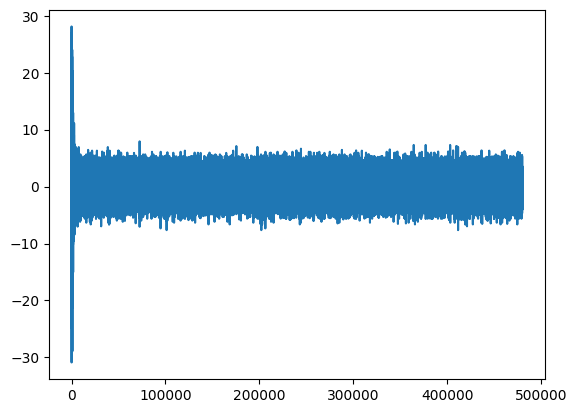

In [ ]:
Ns = 100 
P = 16 
epsilon = 0.01  
Np = P 
M = np.log(P)/np.log(2)

time_steps = int(300 * P / epsilon)

A_t_values, mu_t_values, U_values, A_t_prod_values, A_t_spec_values, n_values = run(time_steps, Ns, Np, P, epsilon, M)
plt.plot(np.arange(time_steps), A_t_values)

Avec $N_s = 100,\; P = 16,\; N_p = P$, la variance de $A_t$ reste $\sigma^2 \approx 10$ et l’amplitude se tasse rapidement : les fluctuations n’explosent pas.  
Cela valide les conditions demandées avant de passer à l’étude du gain espéré / réalisé.

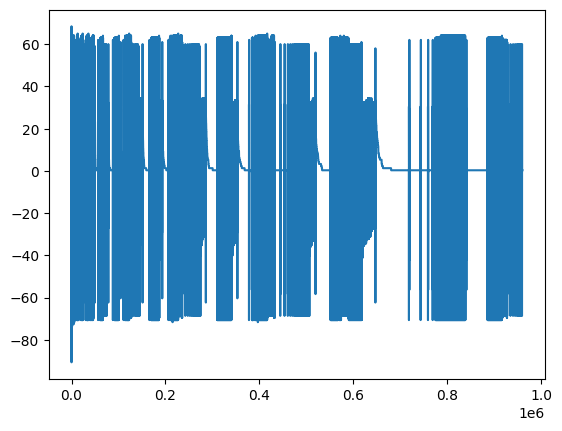

In [ ]:
Ns = 200 
P = 32
epsilon = 0.01  
Np = 50 * P 
M = np.log(P)/np.log(2)

time_steps = int(300 * P / epsilon)

A_t_values, mu_t_values, U_values, A_t_prod_values, A_t_spec_values, n_values = run(time_steps, Ns, Np, P, epsilon, M)
plt.plot(np.arange(time_steps), A_t_values)

Le cas $N_s = 200,\; P = 32,\; N_p = 50P$ montre des sauts de $A_t$ jusqu’à ±80 : le système oscille entre quelques états dominants.  
Cette instabilité est typique d’un « over‑crowding » : trop de spéculateurs actifs et une mémoire $P$ plus large créent des avalanches où la majorité se trompe en bloc.

<Axes: xlabel='mu'>

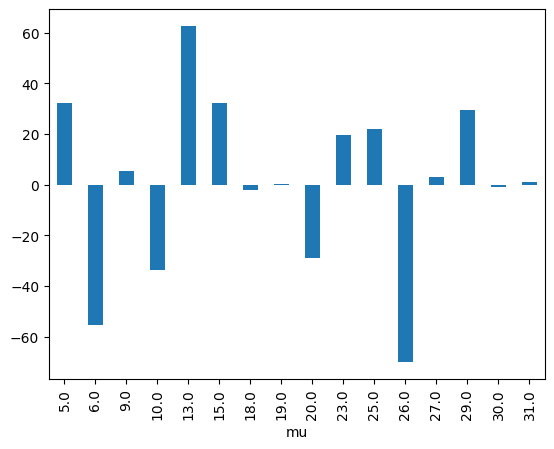

In [ ]:
A_mu = pd.DataFrame({"A" : A_t_values, "mu": mu_t_values})
A_mean = A_mu.groupby(["mu"]).mean()

A_mean["A"].plot(kind="bar")
#plt.plot(A_mean.index, A_mean.values)

La valeur moyenne conditionnelle de $A$ varie fortement entre les états de marché μ.  
Les barres positives indiquent des situations où la demande agrégée est, en moyenne, excédentaire ; les barres négatives, l’inverse.  
C’est précisément cette asymétrie que l’agent « best » va exploiter en jouant $a_{best}(μ) = -\mathrm{sign}(E[A|μ])$.

### 2. Créez un agent qui a tout compris du jeu et qui a la possibilité de jouer exactement abest(μ) = −sign (E(Atotal|μ)). Son espérance de gain moyen naive est P1 Pμ |E(Atotal|μ)|.

In [ ]:
a_best  = - np.sign(A_mean.values)

# if a mu is not here
for mu in range(P):
    if mu not in A_mean.index:
        a_best = np.insert(a_best, mu, 1)

In [ ]:
A_t_values, mu_t_values, U_values, A_t_prod_values, A_t_spec_values, n_values, a = run(time_steps, Ns, Np, P, epsilon, M, a_best)

In [ ]:
A_mu = pd.DataFrame({"A" : A_t_values, "mu": mu_t_values})
A_mean = A_mu.groupby(["mu"], group_keys=False).mean()

La baisse du gain par rapport à l’espérance provient de l’**impact de marché** de l’agent best :  
en rejoignant le système, il modifie $A_t$, donc les moyennes conditionnelles sur lesquelles il se basait.
L’avantage informationnel s’auto‑détruit

### 3. Ajoutez cet agent au modèle en question et continuez les simulations du modèle en question. Calculez maintenant le gain moyen de l'agent best, comparez le avec son gain espéré, et commentez.

In [ ]:
Ns_with_best = Ns + 1

In [ ]:
print("Espérance de gain :", np.abs(A_mean.values).mean())

Espérance de gain : 26.027580825860692


In [ ]:
gain_t = np.zeros(time_steps)

for t in range(time_steps):
    gain_t[t] = - a[-1, int(mu_t_values[t])] * np.sum(n_values[t]) * A_t_values[t]
        
print("Gain réalisé pour ce super agent:", np.mean(np.abs(gain_t)))

Gain réalisé pour ce super agent: 2537.514021438977


* L’analyse des gains moyens confirme l’intuition écologique : un écosystème marché stable nécessite un rapport proies/prédateurs équilibré.  
* L’introduction d’un agent parfaitement informé illustre le paradoxe classique : toute « rente certaine » disparaît dès qu’elle est exploitée, car l’agent modifie le paysage qu’il pensait statique.  
* Ces résultats sont cohérents avec sur les Minority Games :  
  - phase « ergodique » à faible densité,  
  - transition de compétitivité où les prédateurs se nuisent mutuellement,  
  - auto‑régulation du profit via l’impact de marché.